# Variational Auto-Encoder without the Cross Entropy Loss

## Importing required packages

In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt

# Defining the model

Model is same as that in [this notebook](https://github.com/ac-alpha/VAEs-using-Pytorch/blob/master/VAE_two_latent_variables.ipynb)

<img src="Architecture_2_latent.png" width="800" />

In [2]:
class VAE(nn.Module):
  
    def __init__(self):
        super(VAE, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 400)
        self.fc2_mu = nn.Linear(400, 2)
        self.fc2_sig = nn.Linear(400, 2)
        self.fc3 = nn.Linear(2, 400)
        self.fc4 = nn.Linear(400, 784)
  
    def encode(self,x):
        a1 = F.relu(self.fc1(x))
        a_mu = self.fc2_mu(a1)
        a_logvar = self.fc2_sig(a1)
        return a_mu, a_logvar
  
    def decode(self,z):
        a3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(a3))
  
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
  
    def forward(self,x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    

# Getting the Dataset

In [3]:
train_dataset = torchvision.datasets.MNIST(root='./data',train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data',train=False, transform=transforms.ToTensor(),download = True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=100, shuffle=False)

## Instantiating the model and optimizer

In [4]:
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## Loss function

Note that here we are not using the KL Divergence loss which tries to make the learned distribution similar to a known distribution.

In [5]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return KLD

# Training

In [6]:
num_epochs = 5
print_per = 100
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    print_loss = 0
    loss_record = []
    for i, (images, _) in enumerate(train_loader):
        images = images.reshape(-1, 28*28)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(images)
        loss = loss_function(recon_batch, images, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        print_loss += loss.item()
        optimizer.step()
        if (i%print_per == 0):
            print("Epoch : {} , Minibatch : {} Loss = {:.4f}".format(epoch+1, i, print_loss))
            loss_record.append(print_loss)
            print_loss = 0
    print("Epoch {} : Loss = ({:.4f}) ".format(epoch+1, train_loss))

Epoch : 1 , Minibatch : 0 Loss = 1.1156
Epoch : 1 , Minibatch : 100 Loss = 27.0651
Epoch : 1 , Minibatch : 200 Loss = 0.9784
Epoch : 1 , Minibatch : 300 Loss = 0.5960
Epoch : 1 , Minibatch : 400 Loss = 0.4124
Epoch : 1 , Minibatch : 500 Loss = 0.3025
Epoch 1 : Loss = (30.6950) 
Epoch : 2 , Minibatch : 0 Loss = 0.0017
Epoch : 2 , Minibatch : 100 Loss = 0.1640
Epoch : 2 , Minibatch : 200 Loss = 0.1372
Epoch : 2 , Minibatch : 300 Loss = 0.0974
Epoch : 2 , Minibatch : 400 Loss = 0.0760
Epoch : 2 , Minibatch : 500 Loss = 0.0606
Epoch 2 : Loss = (0.5840) 
Epoch : 3 , Minibatch : 0 Loss = 0.0003
Epoch : 3 , Minibatch : 100 Loss = 0.0336
Epoch : 3 , Minibatch : 200 Loss = 0.0281
Epoch : 3 , Minibatch : 300 Loss = 0.0235
Epoch : 3 , Minibatch : 400 Loss = 0.0204
Epoch : 3 , Minibatch : 500 Loss = 0.0158
Epoch 3 : Loss = (0.1360) 
Epoch : 4 , Minibatch : 0 Loss = 0.0002
Epoch : 4 , Minibatch : 100 Loss = 0.0119
Epoch : 4 , Minibatch : 200 Loss = 0.0100
Epoch : 4 , Minibatch : 300 Loss = 0.0090
E

(784,)
torch.Size([784])


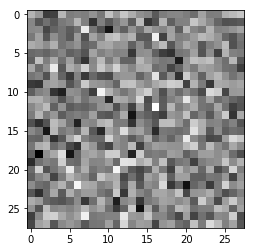

In [7]:
print(model(images)[0].data[0].numpy().shape)
image1 = images[8]
print(image1.shape)
plt.imshow(model(images)[0].data[8].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

# Testing

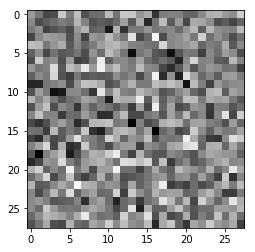

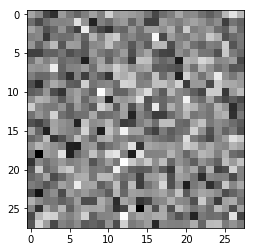

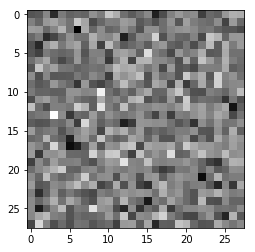

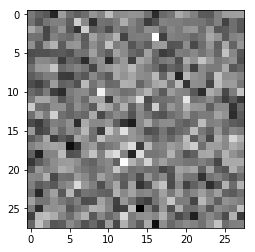

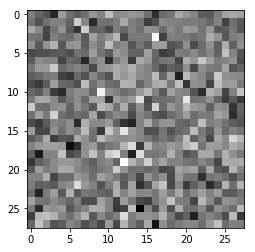

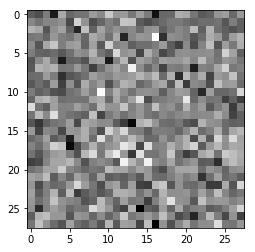

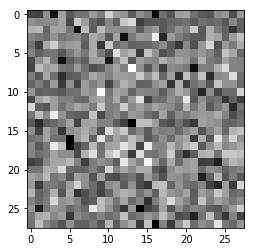

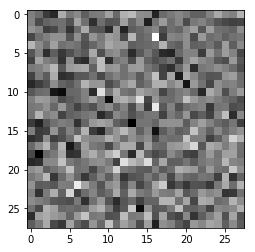

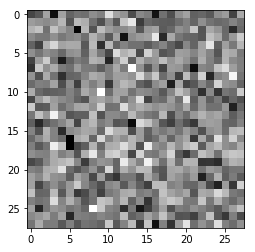

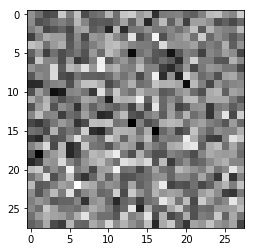

In [8]:
test_loss = 0
print_per = 10
with torch.no_grad():
    for i, (images, _) in enumerate(test_loader):
        images = images.reshape(-1, 28*28)
        recon_batch, mu, logvar = model(images)
        test_loss += loss_function(recon_batch, images, mu, logvar).item()
        if (i%print_per == 0):
            plt.imshow(model(images)[0].data[0].numpy().reshape(28, 28), cmap='gray')
            plt.show(block=True)

In [9]:
image2 = images[1]
print(image2.shape)

torch.Size([784])


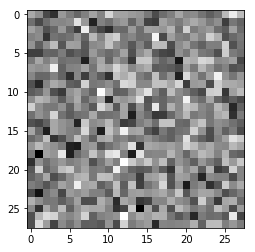

In [10]:
plt.imshow(model(images)[0].data[1].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

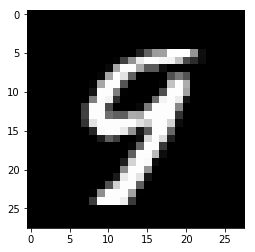

In [11]:
plt.imshow(images[1].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

# Experiments

In [12]:
with torch.no_grad():
    mu1, logvar1 = model.encode(image1)
    std1 = torch.exp(0.5*logvar1)
    mu2, logvar2 = model.encode(image2)
    std2 = torch.exp(0.5*logvar2)

In [13]:
with torch.no_grad():
    recon_images1 = []
    for ctr in range(0, 100, 5):
        eps_val = torch.full_like(mu1, fill_value = ctr * 0.01 )
        z_val1 = eps_val.mul(std1).add_(mu1)
        recon_image1 = model.decode(z_val1)
        recon_images1.append(recon_image1)

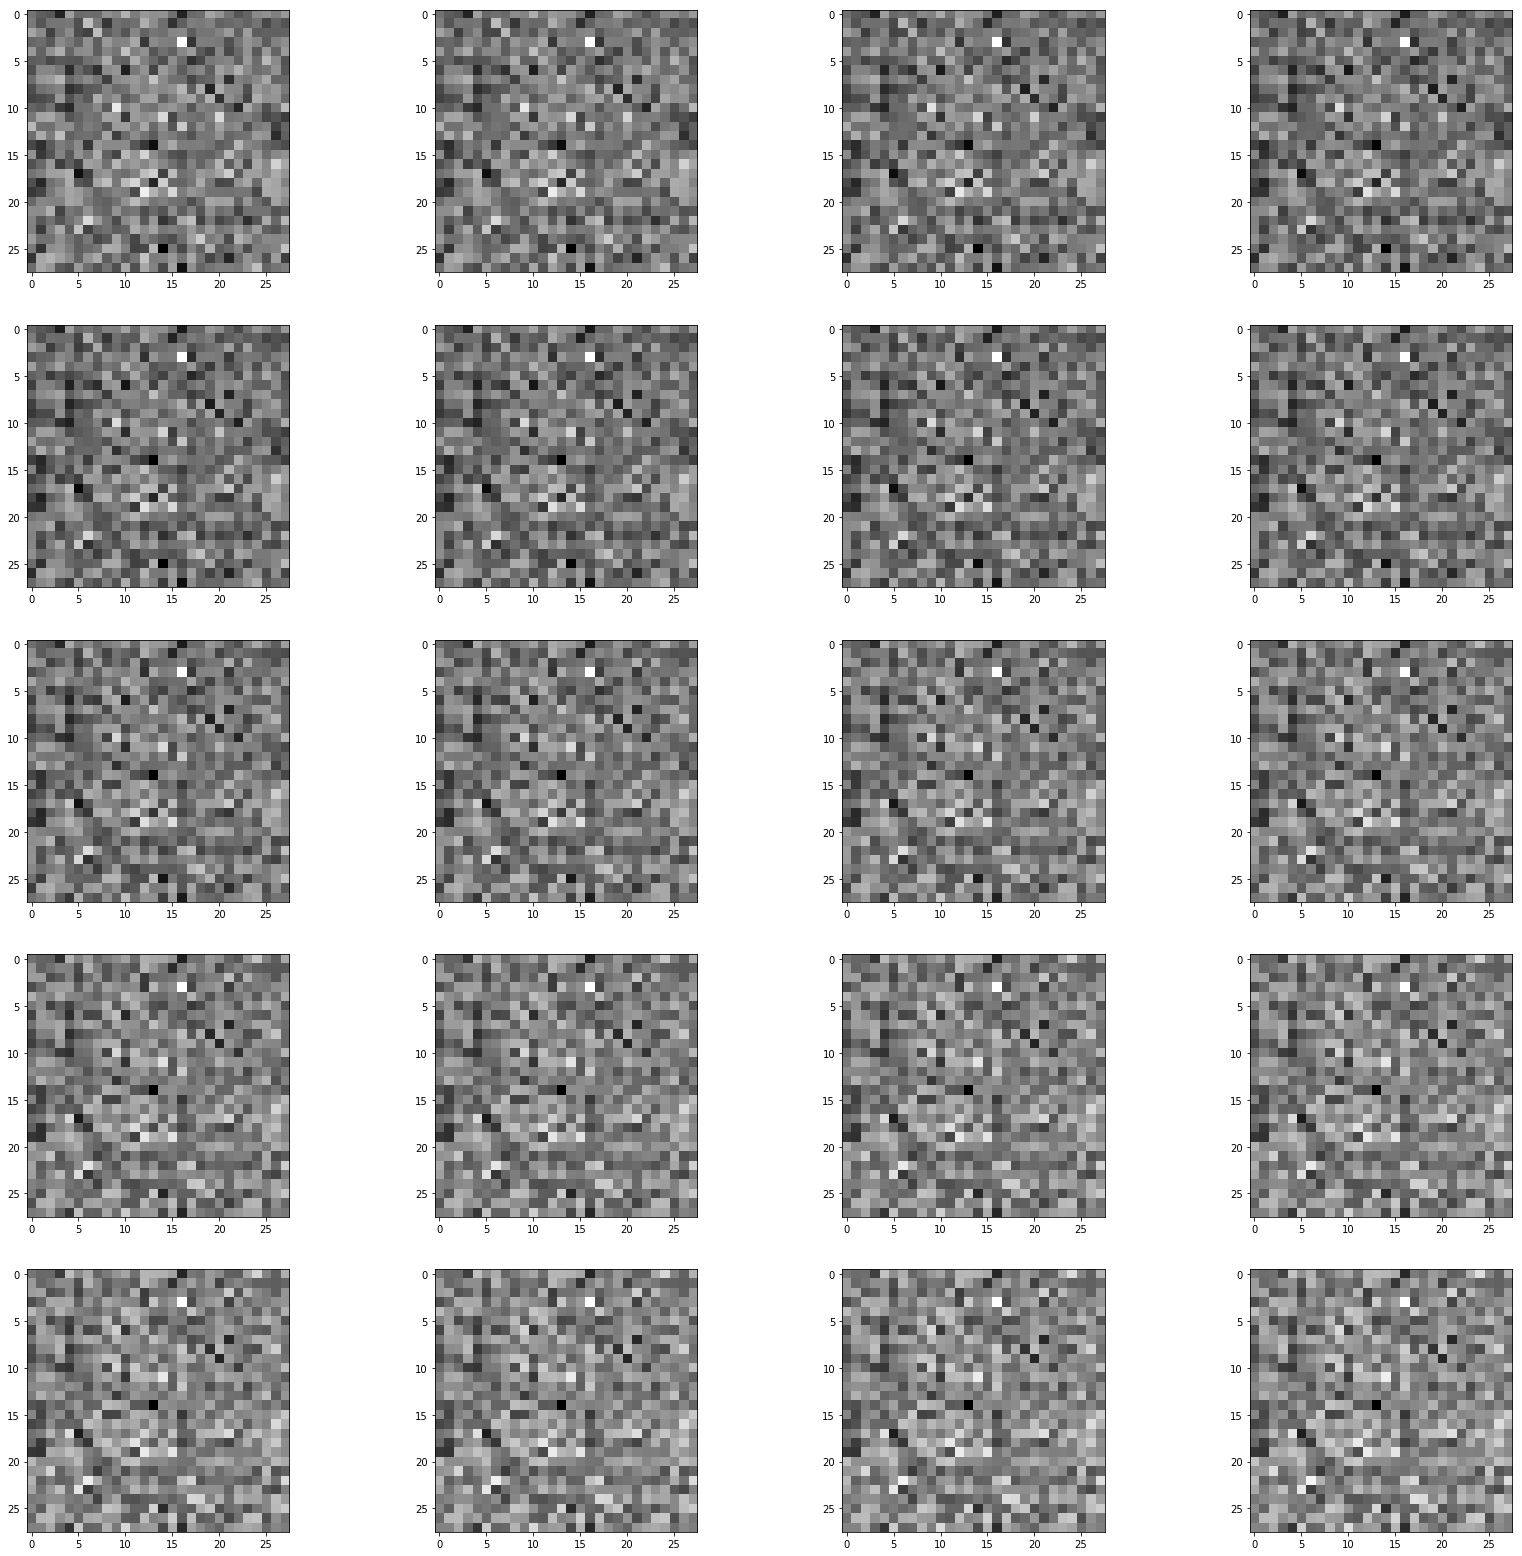

In [21]:
fig=plt.figure(figsize=(28, 28))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = recon_images1[i-1].detach().numpy().reshape(28, 28)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap="gray")
plt.show()

In [22]:
eps_any = torch.randn_like(mu1)
z1 = eps_any.mul(std1).add_(mu1)
z2 = eps_any.mul(std2).add_(mu2)
all_recons = []
for i in range(20):
    z_bet = z1 + torch.full_like(mu1, fill_value = 0.05*i).mul(z2 - z1)
    recon_image = model.decode(z_bet)
    all_recons.append(recon_image)

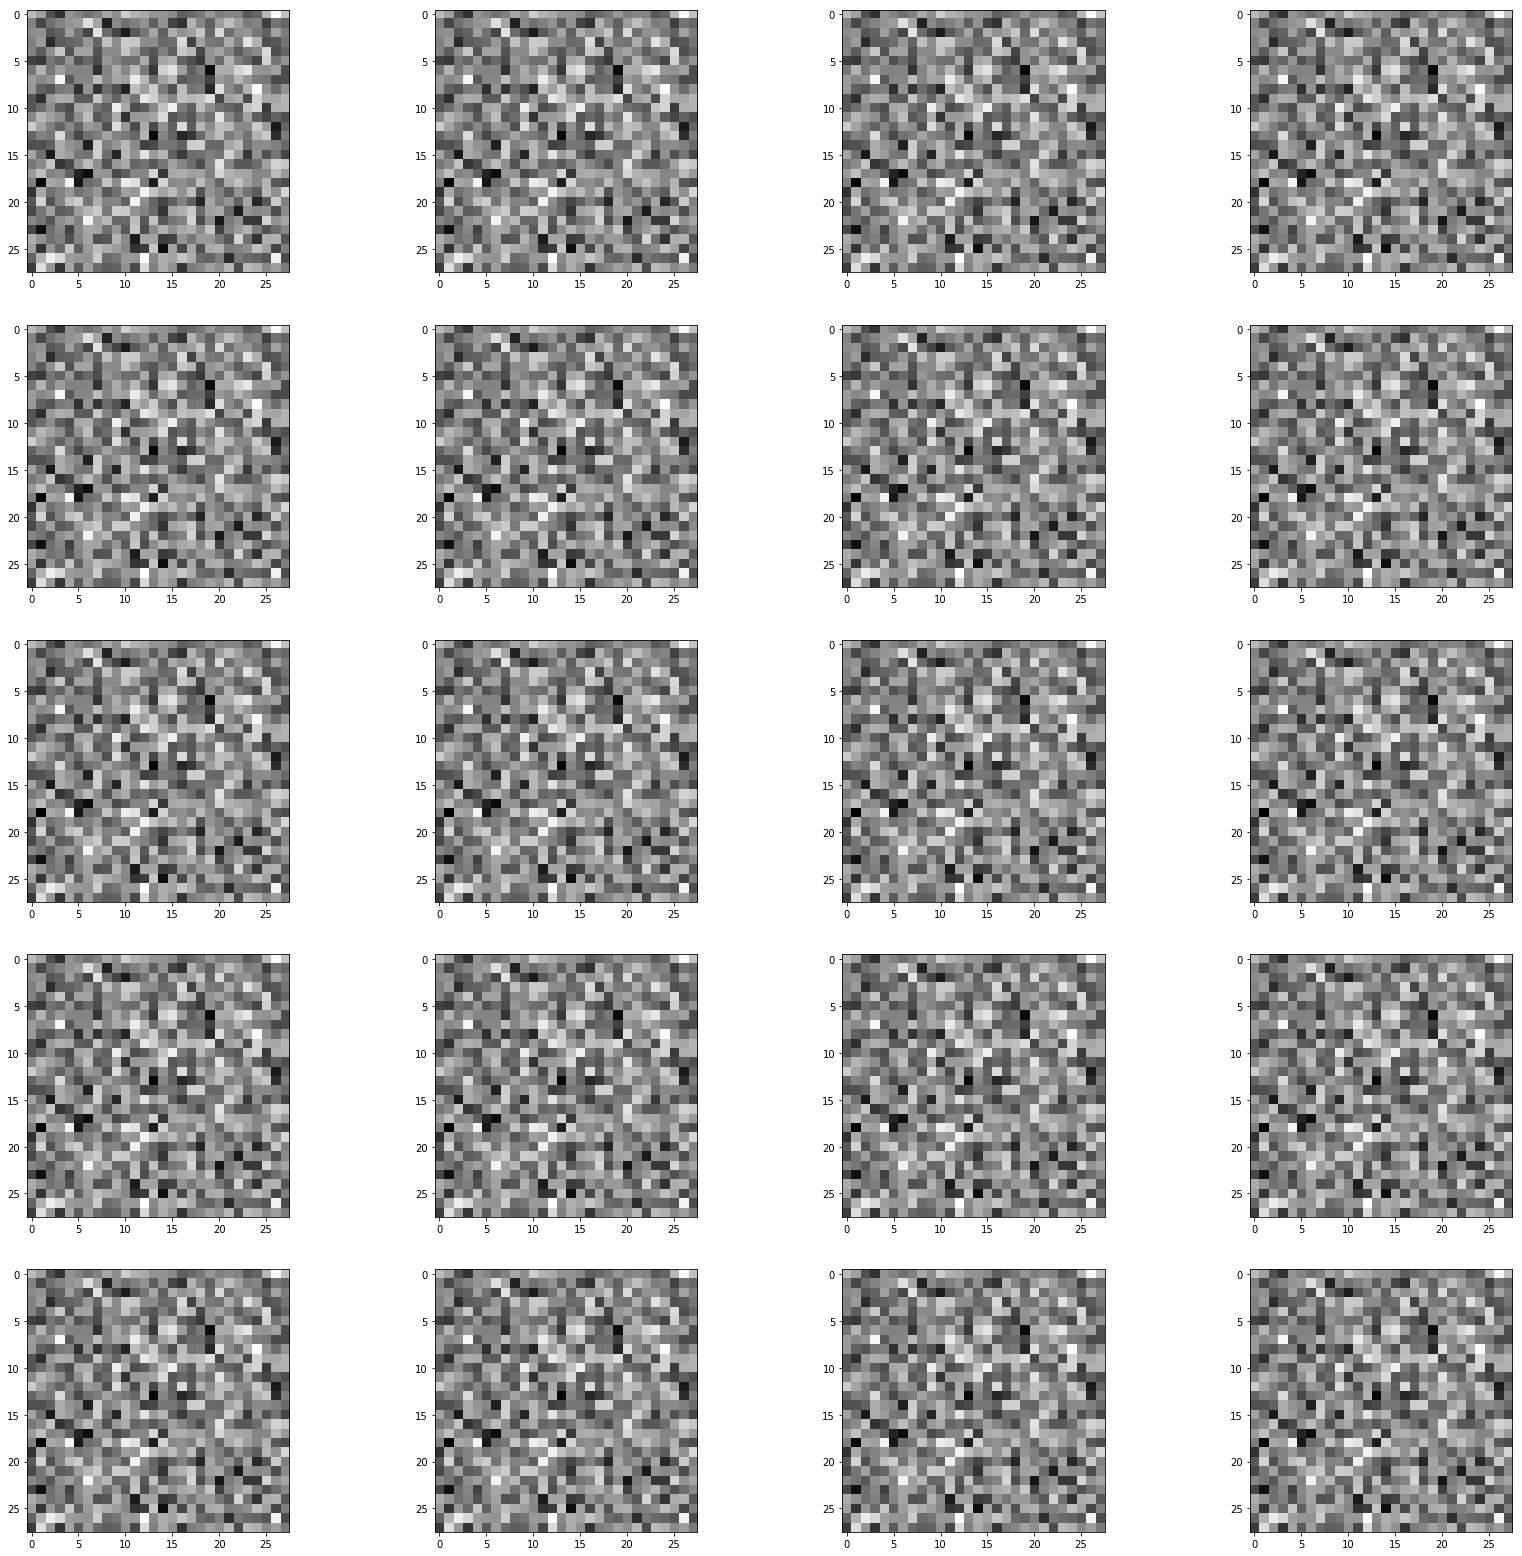

In [23]:
fig=plt.figure(figsize=(28, 28))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = all_recons[i-1].detach().numpy().reshape(28, 28)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap="gray")
plt.show()

### 8. Here in the scatter plot we see that the points belonging to all the digits are mixed up at random but they are very close to each other.

In [18]:
test_dataset = torchvision.datasets.MNIST(root='./data',train=False, transform=transforms.ToTensor(),download = True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=2000, shuffle=False)

In [19]:
x_set, y_set = next(iter(test_loader))
x_set = x_set.reshape(-1, 28*28)
z_set = model.encode(x_set)[0].detach().numpy()
color = y_set

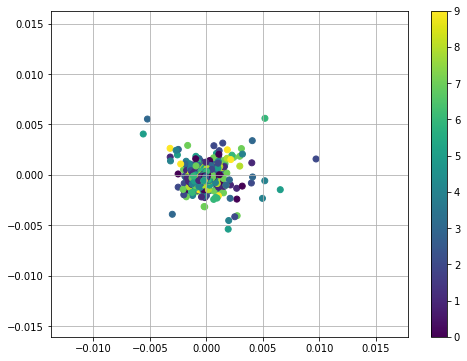

In [20]:
plt.figure(figsize=(8,6))
plt.scatter(z_set[:, 0], z_set[:, 1], c=color, cmap = "viridis")
plt.colorbar()
plt.grid()